# Rb HF Zeeman Shifts

my Zeeman hamiltonian code might have an error (in amophys), because I do not observe a zero differential shift between 5S1/2 |2,1> and |1,-1> at 3.23 G as has been noted in, e.g, Heather Lewandowski's thesis from the Cornell group

In [1]:
#### libraries
from matplotlib import pyplot as plt
from sympy.utilities.iterables import flatten
import numpy as np
from numpy.linalg import eig

#### local files
from rbconsts import *
from physconsts import *
from amophys import *

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

imdir = "./images/" # where to save images

# important: 'I' is the nuclear spin, not sympy imaginary i. Use
# numpy's 1j for imaginary i. 

C:\Users\prest\AppData\Local\Temp\ipykernel_24476\3722598502.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML


## 5S1/2,5P3/2 HF shifts

In [2]:
## HF Hamiltonian:
numstates = 3 + 5 + 1 + 3 + 5 + 7 # 5S1/2 & 5P3/2 hyperfine states
H_a = np.zeros((numstates,numstates))

i = 0
n = 5
exclude = [(1,1/2)] # don't include P1/2

for l in [0,1]:
    for j in j3_from_j1j2(l,1/2):
        for f in j3_from_j1j2(j,I):
            if (l,j) not in exclude:
                for mf in np.arange(-f,f+1):
                    H_a[i,i] = GHzToeV(hf_states[n][l][j][f])
                    i += 1

## For each B value, build Zeeman Hamiltonian and diag. H full

bsteps = 50
solution = empty((numstates, bsteps))
Bzlist = np.linspace(0,.010,bsteps)

fbasis = np.concatenate((jmbasis([1,2]), jmbasis([0,1,2,3])))
lstates = np.concatenate((np.zeros(8), np.zeros(16)))
jstates = np.concatenate((0.5*np.ones(8), 1.5*np.ones(16)))
for sol_idx,Bz in enumerate(Bzlist):
    H_z1 = np.zeros((numstates,numstates),dtype=float)
    for i,state_i in enumerate(fbasis):
        f,mf = state_i
        for j,state_j in enumerate(fbasis):
            if lstates[i] == lstates[j] and jstates[i] == jstates[j]:
                
                gJ = gJ_fn(jstates[j],lstates[j],s,gL,gS)
                ff,mff = state_j
                states = [I,jstates[j],f,mf,ff,mff]
                try:
                    H_z1[i,j] = JToeV(hf_zeeman(states,gJ,gI,Bz))
                except Exception as e:
                    print(e)
                    print("Failed: %s" % states)
                
    # Diagonalize the full Hamiltonian
    evals_sorted = empty(numstates)
    
    H_full = H_a + H_z1
    evals,evecs = np.linalg.eigh(H_full)  
    evals_sorted = sort(evals)
    solution[:,sol_idx] = evals_sorted
    
print("computed Zeeman shifts")

computed Zeeman shifts


In [3]:
shift_factors = np.empty(len(fbasis),dtype=object)
i = 0
# for i,fmstate in enumerate(fbasis):
for l in [0,1]:
    for j in j3_from_j1j2(l,1/2):
        for f in j3_from_j1j2(j,I):
            if (l,j) not in exclude:
                for mf in np.arange(-f,f+1):
                    if f != 0:
                        gF = gF_fn(f,j,I,gJ_fn(j,l,s,gL,gS),gI)
                    else:
                        gF = 0 # actually nan, but mf=0 so doesn't matter
                    print(f"F={f}: mf gF = {mf}*{gF} = {mf*gF}")
                    shift_factors[i] = [(int(f),int(mf)), mf*gF]
                    i += 1

F=1.0: mf gF = -1.0*-0.50130125 = 0.50130125
F=1.0: mf gF = 0.0*-0.50130125 = -0.0
F=1.0: mf gF = 1.0*-0.50130125 = -0.50130125
F=2.0: mf gF = -2.0*0.49931125000000004 = -0.9986225000000001
F=2.0: mf gF = -1.0*0.49931125000000004 = -0.49931125000000004
F=2.0: mf gF = 0.0*0.49931125000000004 = 0.0
F=2.0: mf gF = 1.0*0.49931125000000004 = 0.49931125000000004
F=2.0: mf gF = 2.0*0.49931125000000004 = 0.9986225000000001
F=0.0: mf gF = -0.0*0 = -0.0
F=1.0: mf gF = -1.0*0.6662075000000001 = -0.6662075000000001
F=1.0: mf gF = 0.0*0.6662075000000001 = 0.0
F=1.0: mf gF = 1.0*0.6662075000000001 = 0.6662075000000001
F=2.0: mf gF = -2.0*0.6662075000000001 = -1.3324150000000001
F=2.0: mf gF = -1.0*0.6662075000000001 = -0.6662075000000001
F=2.0: mf gF = 0.0*0.6662075000000001 = 0.0
F=2.0: mf gF = 1.0*0.6662075000000001 = 0.6662075000000001
F=2.0: mf gF = 2.0*0.6662075000000001 = 1.3324150000000001
F=3.0: mf gF = -3.0*0.6662075000000001 = -1.9986225000000002
F=3.0: mf gF = -2.0*0.6662075000000001 = -1

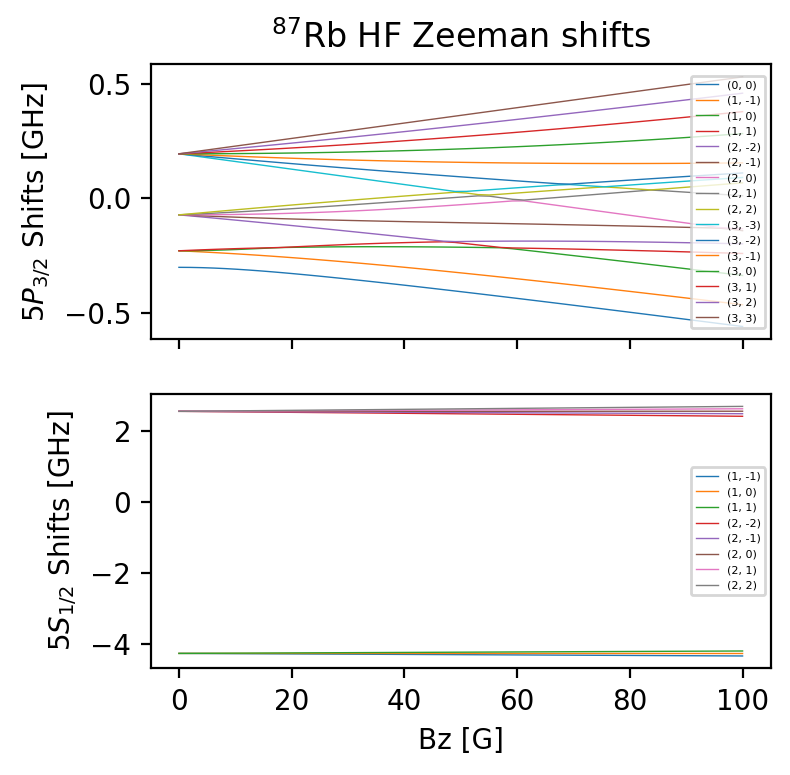

In [4]:
fig,(ax,ax2) = plt.subplots(2,1,dpi=200,figsize=(4,4),sharex=True)
fm_labels = [shift_factors[i][0] for i in range(len(shift_factors))]
legfntsize = 4

zshifts_g = solution[:8,]
labels_g = fm_labels[:8]
zshifts_e = solution[8:,]
labels_e = fm_labels[8:]

lw = 0.5
ax.set_title(r"$^{87}$Rb HF Zeeman shifts")
for shift,l in zip(zshifts_e,labels_e):
    ax.plot(Bzlist/1e-4, eVToGHz(shift)-nu_D2/1e9,linewidth=lw,
            label=l)

ax.set_ylabel(r"$5P_{3/2}$ Shifts [GHz]")
ax.legend(loc="center right", fontsize=legfntsize)


for shift,l in zip(zshifts_g,labels_g):
    ax2.plot(Bzlist/1e-4, eVToGHz(shift),linewidth=lw,
            label=l)
# ax2.plot(Bzlist/1e-4, eVToGHz(zshifts_g),linewidth=lw,
#         label=labels_g)
ax2.legend(loc='center right', fontsize=legfntsize)
ax2.set_yticks([-4,-2,0,2])
ax2.set_ylabel("$5S_{1/2}$ Shifts [GHz]")
ax2.set_xlabel("Bz [G]")
# fname = imdir+"hf_zeeman_shifts_5p32_5s12_0_100G.png"
# plt.savefig(fname, bbox_inches='tight')
plt.show()

# len(labels_g),len(zshifts_g.T)

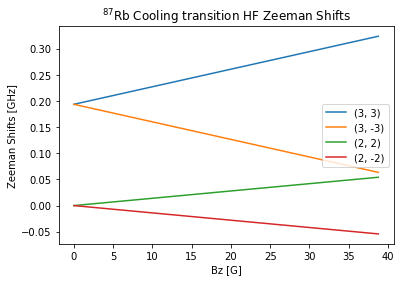

In [5]:
fig,ax = plt.subplots()

g1_idx = -1
g2_idx = -5
e1_idx = -1
e2_idx = -7
last = 20
ax.plot(Bzlist[:last]/1e-4, eVToGHz(zshifts_e[e1_idx][:last])-nu_D2/1e9,label=labels_e[e1_idx])
ax.plot(Bzlist[:last]/1e-4, eVToGHz(zshifts_e[e2_idx][:last])-nu_D2/1e9,label=labels_e[e2_idx])
ax.plot(Bzlist[:last]/1e-4, eVToGHz(zshifts_g[g1_idx][:last])-hf_states[5][0][1/2][2],label=labels_g[g1_idx])
ax.plot(Bzlist[:last]/1e-4, eVToGHz(zshifts_g[g2_idx][:last])-hf_states[5][0][1/2][2],label=labels_g[g2_idx])

ax.set_title(r"$^{87}$Rb Cooling transition HF Zeeman Shifts")
ax.set_ylabel(r"Zeeman Shifts [GHz]")
ax.set_xlabel("Bz [G]")
ax.legend(loc="center right")#, fontsize=legfntsize)

# fname = imdir+"hf_zeeman_shifts_cooling_2_to_3_0_40G.png"
# plt.savefig(fname, bbox_inches='tight')

in direction positive field, the differential splitting is positive and m=2->m'=3 becomes detuned from the light. -2 -> -3 splitting is negative and comes into resonance with light, so light with k vector anti-parallel to the B-field should have sigma- polarization.  

## 5S1/2 shifts only

In [13]:
#### Rb87 5s1/2 HF Zeeman Shifts:
L = 0; S = 1/2; J = 1/2;
Flist = [2,1] # F = I + J

E_5sF2 = GHzToeV(2.56300597908911) # GHz
E_5sF1 = GHzToeV(-4.27167663181519) # GHz

gJ = gJ_fn(J,L,S,gL,gS)

steps = 30
Bzlist = np.linspace(0,.05,steps)

# TODO: make hf energies above/below com energy
E_hf = GHzToeV(nu_hf) # assign numeric value to ease diagonalization (?)

# Rb Hamiltonian for HF ground states in {|F,mF>} basis
dim = 8
H_a = zeros((dim,dim))
for i in range(dim):
    if i < 5:
        H_a[i,i] = E_5sF2
    else: 
        H_a[i,i] = E_5sF1

solution = empty((dim, steps))        

# Zeeman Hamiltonian for B = Bz
for sol_idx,Bz in enumerate(Bzlist):
    
    H_Zz = np.empty((dim,dim))
    basis = jmbasis(Flist)
    for i,state_i in enumerate(basis):
            F,mF = state_i
            for j,state_j in enumerate(basis):
                FF,mFF = state_j
                states = [I,J,F,mF,FF,mFF]
                try:
                    H_Zz[i,j] = JToeV(hf_zeeman(states,gJ,gI,Bz))
                except:
                    print("Failed: %s" % states)
                    
    evals_sorted = empty(dim)
    
    H_full = H_a + H_Zz
    evals,evecs = np.linalg.eigh(H_full)
    
    # sort e-vals by overlap of state with previous basis vectors
    
    # iterating this way leads to using redundant values apparently
#     for k in range(dim): 
#         idx = np.argsort([np.vdot(evecs[:,l],ovecs[:,k]) for l in range(dim)])[-1]
#         evals_sorted[k] = evals[idx]
    evals_sorted = sort(evals)
    solution[:,sol_idx] = evals_sorted
    
print("computed Zeeman shifts")

computed Zeeman shifts


Text(0.5, 0, 'B [G]')

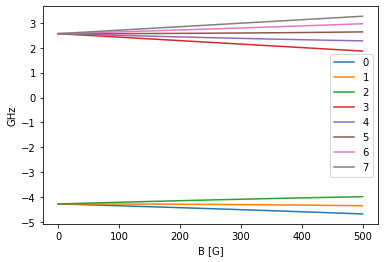

In [45]:
fig, ax = plt.subplots() #ncols=2)
# ax,ax1= axes
for i in range(dim):
    ax.plot(Bzlist*1e4, eVToGHz(solution[i,:]),label=i)
ax.legend()
ax.set_ylabel('GHz')
ax.set_xlabel('B [G]')


# ax.plot(Bzlist, solution[6,:]-solution[7,:])

Text(0.5, 0, 'B [G]')

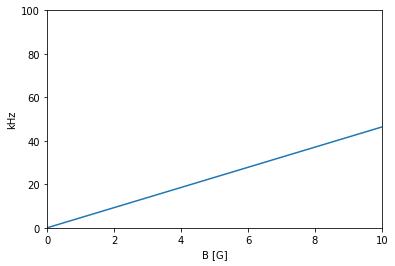

In [55]:
## plot differential shifts for selected states

fig, ax = plt.subplots()

ax.plot(Bzlist*1e4, (eVToGHz(solution[6,:]) - hf_states[5][0][1/2][2] - (eVToGHz(solution[2,:]) - hf_states[5][0][1/2][1]))*1e6)
ax.set_xlim((0,10))
ax.set_ylim((0,100))
ax.set_ylabel('kHz')
ax.set_xlabel('B [G]')

# ax.plot(Bzlist, solution[6,:]-solution[7,:])

For small fields, the Zeeman shift is linear and we can pick off the value of the shift by subtracting the unshifted state energies

In [31]:
FF,mFF = state_j
# states = [I,J,F,mF,FF,mFF]
state_list = [[I,1/2,1,1,1,1],[I,1/2,1,-1,1,-1]]
Bz = 3.2e-4
for states in state_list:
    print(eVToGHz(JToeV(hf_zeeman(states,gJ,gI,Bz))-E_5sF1)*1e3, "MHz")

-2.24522482378748 MHz
2.24522482378748 MHz


What is the differential shift between these states in this regime?

Text(0, 0.5, 'MHz')

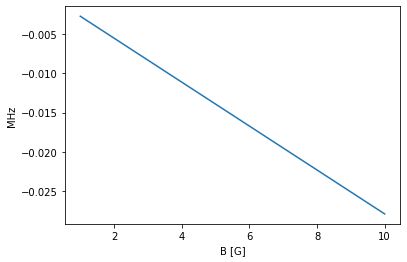

In [58]:
Bz_list = linspace(1,10,10)*1e-4

# our readout states in the network experiment
state1 = [I,1/2,1,-1,1,-1]
state2 = [I,1/2,2,1,2,1]
# 
dshift = array([eVToGHz(JToeV(hf_zeeman(state2,gJ,gI,Bz) - hf_zeeman(state1,gJ,gI,Bz))) for Bz in Bz_list])*1e3
fig,ax = plt.subplots()
ax.plot(Bz_list*1e4,dshift)
ax.set_xlabel('B [G]')
ax.set_ylabel('MHz')